# CNN for CIFAR-10 with Dropout Layers

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

In [ ]:
import numpy as np

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

### Description



Classification of the CIFAR-10 dataset using using a convolutional neural network (CNN) with and without dropout layers.

### GPU

CNNs run very efficiently on a GPU. If a GPU is available we definitely want to take advantage of it. We can automatically set a `device` variable which will define a GPU if it's available and otherwise fallback to a CPU:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Set

### CIFAR-10

The CIFAR-10 dataset is a benchmark dataset for computer vision containing 60000 images divided in 10 classe. The dataset is composed of different photographs of the following classes: airplane, automobile, bird, cat deer, dog, frog, horse, ship, truck. The images are $32 \times 32$ pixels in size and are composed of three channels (RGB).

### Loading the Dataset

As usual, we want to load the data into`torch.tensor`s and apply a transformation so that the data is normalised in order to reduce data skewness. We use the `transforms.Normalize` function in order to normalise our data.

In [ ]:
# Define usual transformation to tensor with normalisation
transform = transforms.Compose(
    [   
        # Transform to tensor and normalise
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# Download and load the training dataset
trainset = datasets.CIFAR10("data", download=True, train=True, transform=transform)

# Download and load the training dataset
testset = datasets.CIFAR10("data", download=True, train=False, transform=transform)

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified



Finally we can define our `DataLoader` and also get some iterators for the datasets:

In [ ]:
# Create DataLoader with batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, drop_last=True)

# Create iterators
trainiter = iter(trainloader)
testiter = iter(testloader)

#### Visualizing Images and Labels

Let's define a dictionary mapping labels (numbers from 0 to 9 denoting one of the 10 CIFAR-10 classes) to the acutal classes names:

In [ ]:
label_to_name = { 
    i : name 
    for i, name in enumerate(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]) 
}

print(label_to_name)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


We can visualise one batch of images from the training set:

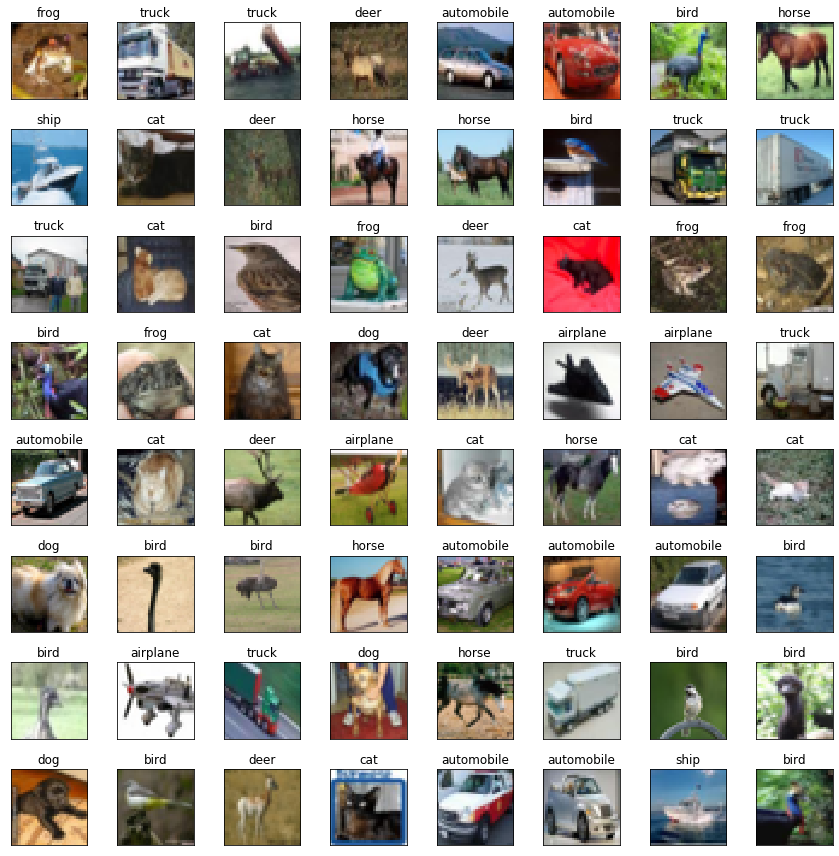

In [ ]:
images, labels = next(trainiter)

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    
    # Un-normalize image
    img = images[idx].numpy() * 0.5 + 0.5 

    plt.imshow(np.transpose(img, (1, 2, 0)))
    
    name = label_to_name[labels[idx].item()]
    
    ax.set_title(name, fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

## CNN woth Dropout Layers

We can now define a CNN with three convolutional and max pooling layers and two fully connected layers. We also add two `nn.Dropout` layers between the last convolutional layer and the first fully connected layer, and between the two fully connected layers. The dropout layers will randomly drop some nodes in of the neural network and therefore act as a regularization technique.

In [ ]:
class CNN(nn.Module):
    def __init__(self, dropoutp = 0.0):

        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.fc = nn.Sequential(
            nn.Dropout(dropoutp),
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(dropoutp),
            nn.Linear(512, 10),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):

         # Input shape
        assert x.shape == (64, 3, 32, 32)

        x = self.conv(x)

        # Flatten features for fully connected layers
        x = x.view(-1, 64 * 4 * 4)

        assert x.shape == (64, 64 * 4 * 4)

        x = self.fc(x)

        assert x.shape == (64, 10)

        return x

_Note_: Here we define the convolutional part (feature detection) and the fully conntected part (classification) of the CNN in two `nn.Sequential` models. This will allow to print out the actual architecture whit `print(model)`.

Once the model is defined we can instanciate it and move it to the `device`:

In [ ]:
modeltest = CNN()
modeltest.to(device)

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): LogSoftmax()
  )
)

### Test Forward Pass

In order to check that our model definition works correctly, we can try to propagate on batch of images through the network. It is important to notice that the data from the `DataLoader` has to be moved to the `device` as well (since the model is now working on the `device`).  We can also plot the class probabilities of this untrained model:

In [ ]:
images, labels = next(trainiter)

# Move images and labels to the GPU
images, labels = images.to(device), labels.to(device)

modeltest.eval()
with torch.no_grad(): # Do not track gradients
    # Perform forward pass
    out = modeltest(images)
            
    # Compute class probabilities
    # The model returns log-probabilities
    p = torch.exp(out)

print(torch.mean(p, dim=0))

tensor([0.0980, 0.1018, 0.0994, 0.1078, 0.0943, 0.0941, 0.1018, 0.1010, 0.0979,
        0.1038], device='cuda:0')


As expected for a model with random weights, the class probabilities for each class are close to $1/10$.

### Training

We can now define our training loop including validation where we also save the parameters of the model leading the the lowest loss on the validation set, which will be useful later. We make the use of  `model.train()` and `model.eval()` to specify when the model is training and when the model is being evaluated (validated).

_Note_: The `nn.Dropout` layers have different behaviours during training (where nodes should be dropped) and evaluation (where nothing should happen). `model.train()` and `model.eval()` are used to make sure that the layers behave correctly.

In [ ]:
def train(model, optimizer, loss_function, trainloader, testloader, paramsfile="model.pth", epochs=30, device=device):
    """
    Train a model by optimizing a loss_function using the given optimizer.
    Model and data are moved to the set device.
    """

    import time
    import os

    # Create directory for parameters file
    savedir = os.path.dirname(paramsfile)
    try:
      os.mkdir(savedir)
    except FileExistsError:
      pass

    # Move model to device
    model.to(device)

    train_losses, valid_losses, accuracies = [], [], []

    min_valid_loss = np.Inf

    # Loop over epochs
    for epoch in range(epochs):

        # Start epoch timer
        time_init = time.time()
        
        # Initialize total epoch loss
        epoch_loss = 0
        
        # Training
        model.train()
        for images, labels in trainloader:

            # Move data to GPU
            images, labels = images.to(device), labels.to(device)
        
            # Initialize the gradients to zero
            optimizer.zero_grad()
            
            # Perform forward pass
            output = model(images)
            
            # Compute the loss
            loss = loss_function(output, labels)
            
            # Perform backpropagation
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            # Accumulate total epoch loss
            epoch_loss += loss.item()
        else:
            valid_loss = 0
            accuracy = 0
            
            # Validation
            # No need totrack gradients during validation
            with torch.no_grad(): 

                model.eval()
                for images, labels in testloader:

                    # Move data to GPU
                    images, labels = images.to(device), labels.to(device)
                    
                    # Perform forward pass
                    output = model(images)
                    
                    # Compute class probabilities
                    p = torch.exp(output)
                    
                    # Compute the loss
                    valid_loss += loss_function(output, labels).item()
                    
                    # Get class of top prediction
                    _, top_c = p.topk(1, dim=1)

                    # Get truth table for the predicted classes
                    equals = (top_c == labels.view_as(top_c)).type(torch.FloatTensor)

                    # Compute accuracy
                    accuracy += torch.mean(equals)
                    
            # Store losses
            train_losses.append(epoch_loss/len(trainloader))
            valid_losses.append(valid_loss/len(testloader))
            accuracies.append(accuracy.item()/len(testloader)*100)

            # Stop epoch timer
            time_end = time.time()

            # Save model
            if valid_losses[-1] < min_valid_loss:
              torch.save(model.state_dict(), paramsfile)
              min_valid_loss = valid_losses[-1]

            if (epoch + 1) % 5 == 0:
              print(f"--- Epoch {epoch+1:2} ---")
              print(f"Train Loss: {train_losses[-1]:.5f}")
              print(f"Valid Loss: {valid_losses[-1]:.5f}")
              print(f"Valid Accuracy: {accuracies[-1]:.2f}%")
              print(f"Time: {time_end - time_init:.3f} s")
    
    return train_losses, valid_losses, accuracies

In [ ]:
# Loss function (for both models)
nll_loss = nn.NLLLoss()

We can not define the model with a dropout probability of `0.5` and train it:

In [ ]:
# Create a model to train with data augmentation
dmodel = CNN(dropoutp=0.5)

# Create an optimizer for training with data augmentation
doptimizer = optim.SGD(dmodel.parameters(), lr=0.05)

dtrainloss, dvalidloss, daccuracy = train(dmodel, 
                                          doptimizer, 
                                          nll_loss,
                                          trainloader,
                                          testloader, 
                                          "models/augmodel.pth",
                                          epochs=50)

--- Epoch  5 ---
Train Loss: 1.23717
Valid Loss: 1.07309
Valid Accuracy: 62.62%
Time: 15.826 s
--- Epoch 10 ---
Train Loss: 0.95629
Valid Loss: 0.86772
Valid Accuracy: 69.54%
Time: 15.772 s
--- Epoch 15 ---
Train Loss: 0.83007
Valid Loss: 0.78218
Valid Accuracy: 72.73%
Time: 15.690 s
--- Epoch 20 ---
Train Loss: 0.75890
Valid Loss: 0.70424
Valid Accuracy: 76.18%
Time: 15.479 s
--- Epoch 25 ---
Train Loss: 0.70407
Valid Loss: 0.68947
Valid Accuracy: 76.01%
Time: 15.575 s
--- Epoch 30 ---
Train Loss: 0.65841
Valid Loss: 0.66583
Valid Accuracy: 76.75%
Time: 15.375 s
--- Epoch 35 ---
Train Loss: 0.62868
Valid Loss: 0.65472
Valid Accuracy: 77.51%
Time: 15.516 s
--- Epoch 40 ---
Train Loss: 0.60851
Valid Loss: 0.65372
Valid Accuracy: 77.56%
Time: 15.566 s
--- Epoch 45 ---
Train Loss: 0.58435
Valid Loss: 0.63985
Valid Accuracy: 78.22%
Time: 15.483 s
--- Epoch 50 ---
Train Loss: 0.56821
Valid Loss: 0.64344
Valid Accuracy: 77.99%
Time: 15.534 s


For comparison, we can also train a model without dropout layers (i.e. with a dropout probability of `0.0`):

In [ ]:
# Create a model to train with data augmentation
model = CNN()

# Create an optimizer for training with data augmentation
optimizer = optim.SGD(model.parameters(), lr=0.05)

trainloss, validloss, accuracy = train(model, 
                                       optimizer, 
                                       nll_loss, 
                                       trainloader, 
                                       testloader, 
                                       "models/model.pth",
                                       epochs=50)

--- Epoch  5 ---
Train Loss: 0.93701
Valid Loss: 0.94876
Valid Accuracy: 66.57%
Time: 15.123 s
--- Epoch 10 ---
Train Loss: 0.46869
Valid Loss: 1.01069
Valid Accuracy: 70.05%
Time: 15.479 s
--- Epoch 15 ---
Train Loss: 0.19728
Valid Loss: 1.42307
Valid Accuracy: 70.09%
Time: 15.324 s
--- Epoch 20 ---
Train Loss: 0.09682
Valid Loss: 1.85897
Valid Accuracy: 68.99%
Time: 15.378 s
--- Epoch 25 ---
Train Loss: 0.05869
Valid Loss: 1.99924
Valid Accuracy: 71.45%
Time: 15.201 s
--- Epoch 30 ---
Train Loss: 0.02923
Valid Loss: 2.13374
Valid Accuracy: 72.58%
Time: 15.271 s
--- Epoch 35 ---
Train Loss: 0.02097
Valid Loss: 2.32677
Valid Accuracy: 71.90%
Time: 15.384 s
--- Epoch 40 ---
Train Loss: 0.03175
Valid Loss: 2.41869
Valid Accuracy: 72.13%
Time: 15.447 s
--- Epoch 45 ---
Train Loss: 0.01614
Valid Loss: 2.49732
Valid Accuracy: 72.18%
Time: 15.453 s
--- Epoch 50 ---
Train Loss: 0.01192
Valid Loss: 2.78366
Valid Accuracy: 71.55%
Time: 15.090 s


After training the model with and without dropouts, we can evaluate the impact of such regularisation technique by plotting the training and validation losses:

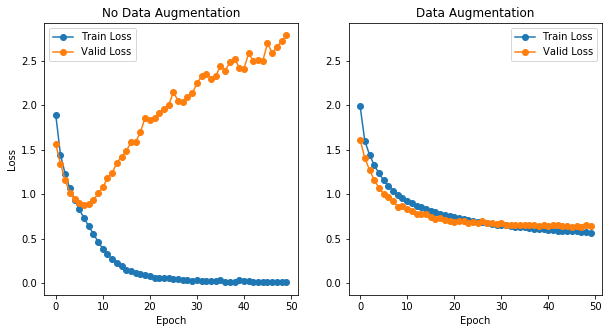

In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(trainloss, "o-", label="Train Loss")
ax1.plot(validloss, "o-", label="Valid Loss")
ax1.set_title("No Data Augmentation")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
ax2.plot(dtrainloss, "o-", label="Train Loss")
ax2.plot(dvalidloss, "o-", label="Valid Loss")
ax2.set_title("Data Augmentation")
ax2.set_xlabel("Epoch")
ax2.legend()
plt.show()

We see that for the model without dropout layers, the validation loss start increasing after a few epochs. This is a clear symptom of overfitting. In contrast, the model with dropout layers allows the validation loss to decrease further, along with the training loss.

We can also look at what happens to the total accuracy on the validation set:

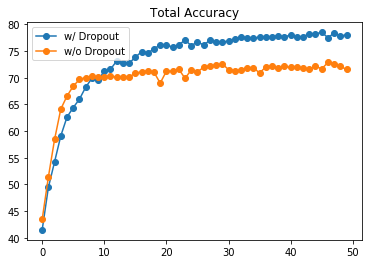

In [ ]:
plt.figure()
plt.plot(daccuracy, "o-", label="w/ Dropout")
plt.plot(accuracy, "o-", label="w/o Dropout")
plt.legend()
plt.title("Total Accuracy")
plt.show()

We see that the model with dropout layers is able to reach an higher overall accuracy.

Finally, we can look at the acccuracy of the predictions:


In [ ]:
from collections import defaultdict

def printaccuracy(model, testloader):
    """
    Compute accuracy for different classes.
    """

    # Stop tracking gradients
    with torch.no_grad(): 
      
      # Put model in evaluation mode
      model.eval()

      # Keep track of correctly assigned classes and total number of classes
      c_correct = defaultdict(int)
      c_total = defaultdict(int)

      for images, labels in testloader:

          # Move data to GPU
          images, labels = images.to(device), labels.to(device)
                    
          # Perform forward pass
          output = model(images)
                    
          # Compute class probabilities
          p = torch.exp(output)
                    
          # Get probability and class of top prediction
          top_p, top_c = p.topk(1, dim=1)

          # Get truth table for the predicted classes
          equals = (top_c == labels.view_as(top_c))

          # Count correctly labelled examples
          for i in range(len(labels)):
              label = labels[i].item()
              c_correct[label] += equals[i].item()
              c_total[label] += 1
    
    for i in range(10):
        correct, total = c_correct[i], c_total[i]
        print(f"Test accuracy of {label_to_name[i]:10}: {correct/total * 100:.2f}% ({correct}/{total})")
    print(f"Test accuracy: {sum(c_correct.values())/sum(c_total.values()) * 100:.2f}%")

In [ ]:
printaccuracy(dmodel, testloader)

Test accuracy of airplane  : 83.37% (832/998)
Test accuracy of automobile: 87.69% (876/999)
Test accuracy of bird      : 64.06% (640/999)
Test accuracy of cat       : 64.49% (643/997)
Test accuracy of deer      : 77.60% (776/1000)
Test accuracy of dog       : 58.07% (579/997)
Test accuracy of frog      : 90.40% (904/1000)
Test accuracy of horse     : 82.85% (826/997)
Test accuracy of ship      : 87.36% (871/997)
Test accuracy of truck     : 84.00% (840/1000)
Test accuracy: 77.99%


In [ ]:
printaccuracy(model, testloader)

Test accuracy of airplane  : 79.96% (798/998)
Test accuracy of automobile: 84.18% (841/999)
Test accuracy of bird      : 50.65% (506/999)
Test accuracy of cat       : 56.07% (559/997)
Test accuracy of deer      : 63.60% (636/1000)
Test accuracy of dog       : 58.48% (583/997)
Test accuracy of frog      : 82.70% (827/1000)
Test accuracy of horse     : 74.82% (746/997)
Test accuracy of ship      : 86.16% (859/997)
Test accuracy of truck     : 78.90% (789/1000)
Test accuracy: 71.55%
